In [1]:
# import things
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [2]:
# REQUIREMENT: Do not add code from Tasks 2 or 4
# REQUIREMENT: All dataset prep (crop/pad/patch/directory structure) must be finalize before attempting this task.

# Configuration
patch_size = 256
batch_size = 32
patch_dir = r"C:\Users\dari\Documents\GitHub\2024-25b-fai2-adsai-dariavladutu236578\datalab_tasks\task4\tuned_dataset"

In [3]:
# Custom F1 Score Metric
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [4]:
def weighted_bce_loss(zero_weight=0.1, one_weight=0.9):
    def loss(y_true, y_pred):
        weights = y_true * one_weight + (1. - y_true) * zero_weight
        bce = K.binary_crossentropy(y_true, y_pred)
        return K.mean(bce * weights)
    return loss

In [5]:
# U-Net Model
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs
    
    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy', f1])
    model.summary()
    return model

In [6]:
# Build U-Net
# REQUIREMENT: Model summary must be visible
model = simple_unet_model(patch_size, patch_size, 1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [7]:
# Setup a generator for training
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)
train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()
train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Combine image and mask generators
train_generator = zip(train_image_generator, train_mask_generator)

Found 22763 images belonging to 1 classes.
Found 22763 images belonging to 1 classes.


In [8]:
# Setup a generator for validation
# Validation images
val_image_datagen = ImageDataGenerator(rescale=1./255)
val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',  # Changed from 'rgb' to 'grayscale'
    seed=42
)

# Validation masks
val_mask_datagen = ImageDataGenerator()
val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Combine val image and mask generators
val_generator = zip(val_image_generator, val_mask_generator)

Found 27342 images belonging to 1 classes.
Found 27342 images belonging to 1 classes.


In [9]:
cb = EarlyStopping(monitor='val_loss', 
                   patience=3, 
                   mode='min', 
                   restore_best_weights=True, 
                   verbose=1)

In [10]:
img_batch, mask_batch = next(train_generator)
print("Image batch shape:", img_batch.shape)
print("Mask batch shape:", mask_batch.shape)

Image batch shape: (32, 256, 256, 1)
Mask batch shape: (32, 256, 256, 1)


In [11]:
print("Train image batches:", len(train_image_generator))
print("Train mask batches :", len(train_mask_generator))

Train image batches: 712
Train mask batches : 712


In [12]:
print("Found", val_image_generator.samples, "images")
print("Found", val_mask_generator.samples, "masks")

Found 27342 images
Found 27342 masks


In [13]:
# This is where the magic happens
# REQUIREMENT: The epoch logs must be visible showing validation loss and validation f1.

validation_steps = val_image_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=[cb],
    verbose=1
)

Epoch 1/30
712/712 [==============================] - 806s 763ms/step - loss: 0.0770 - accuracy: 0.9760 - f1: 0.5089 - val_loss: 0.0051 - val_accuracy: 0.9984 - val_f1: 0.7352
Epoch 2/30
712/712 [==============================] - 381s 536ms/step - loss: 0.0354 - accuracy: 0.9859 - f1: 0.7951 - val_loss: 0.0056 - val_accuracy: 0.9983 - val_f1: 0.7532
Epoch 3/30
712/712 [==============================] - 407s 572ms/step - loss: 0.0315 - accuracy: 0.9872 - f1: 0.8159 - val_loss: 0.0033 - val_accuracy: 0.9987 - val_f1: 0.8139
Epoch 4/30
712/712 [==============================] - 393s 552ms/step - loss: 0.0299 - accuracy: 0.9877 - f1: 0.8246 - val_loss: 0.0034 - val_accuracy: 0.9987 - val_f1: 0.8037
Epoch 5/30
712/712 [==============================] - 377s 530ms/step - loss: 0.0289 - accuracy: 0.9880 - f1: 0.8297 - val_loss: 0.0033 - val_accuracy: 0.9988 - val_f1: 0.8086
Epoch 6/30
712/712 [==============================] - 373s 524ms/step - loss: 0.0281 - accuracy: 0.9883 - f1: 0.8338 - v

1/1 [==============================] - 0s 241ms/step


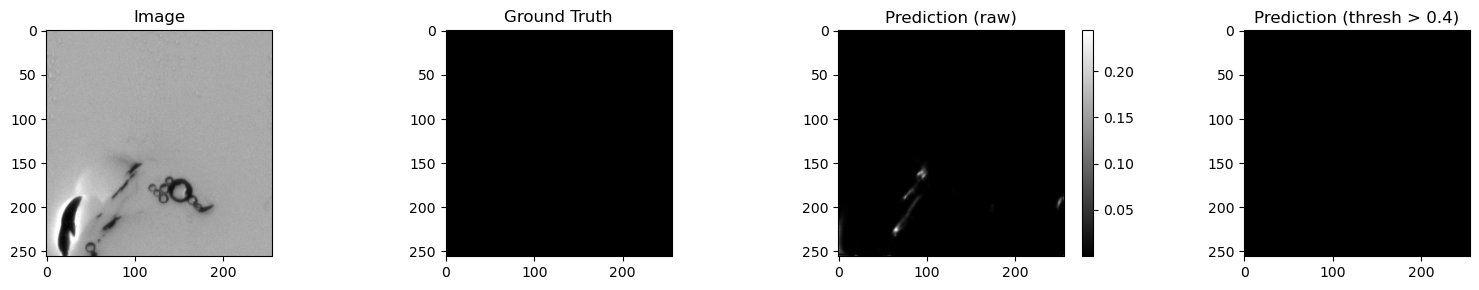

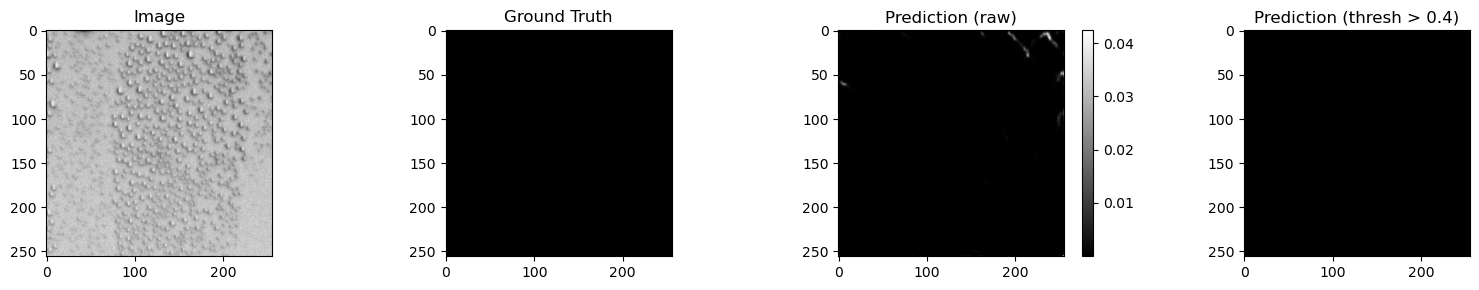

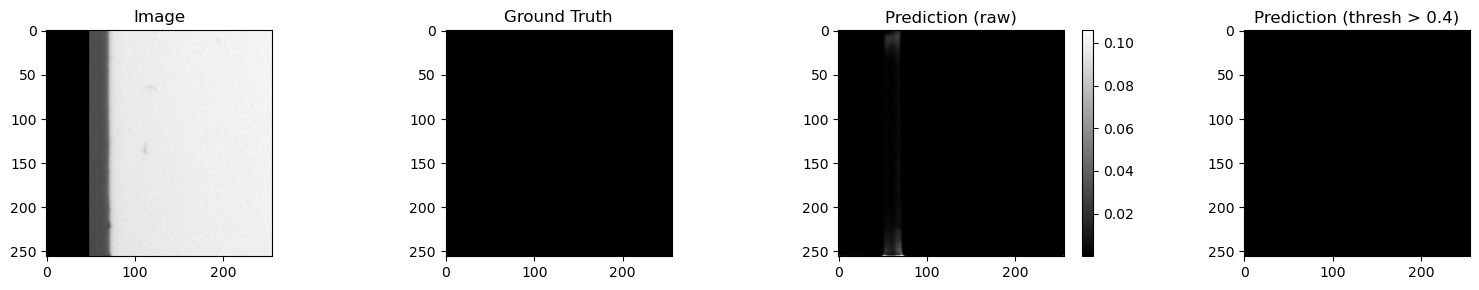

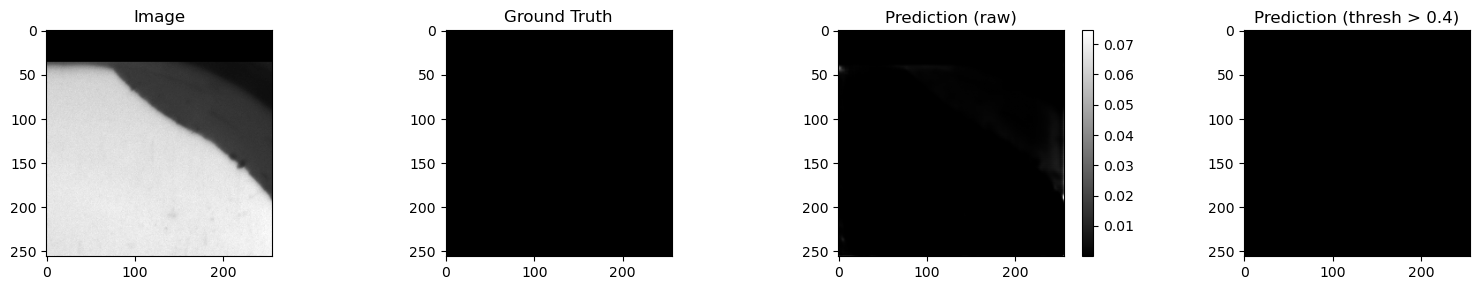

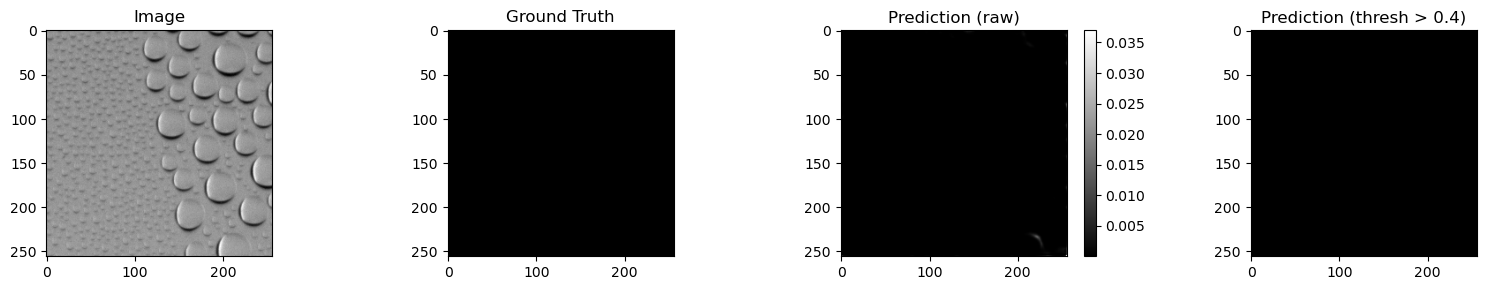

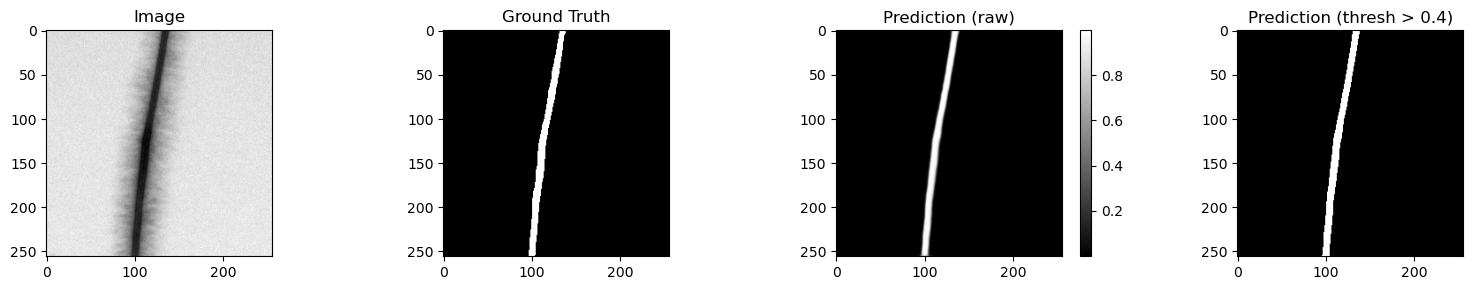

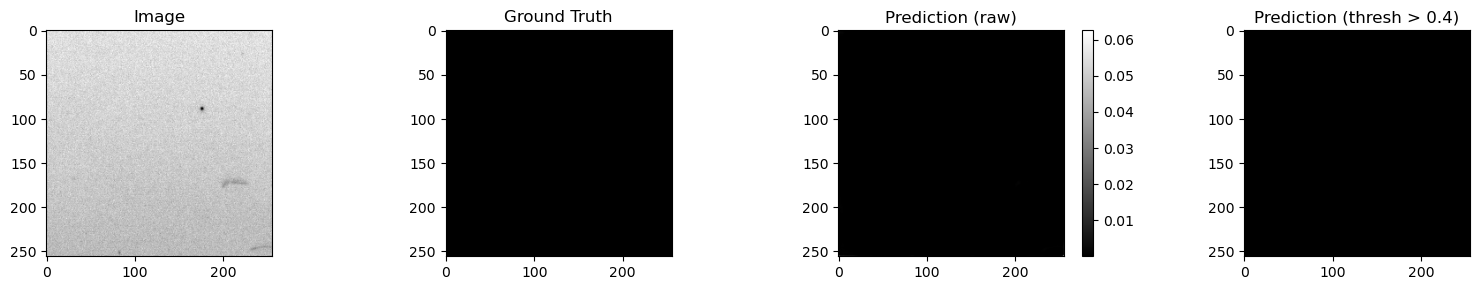

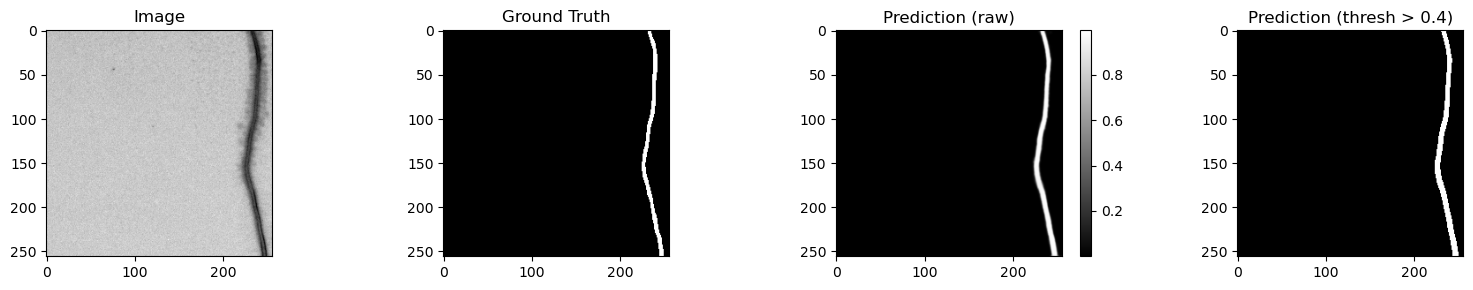

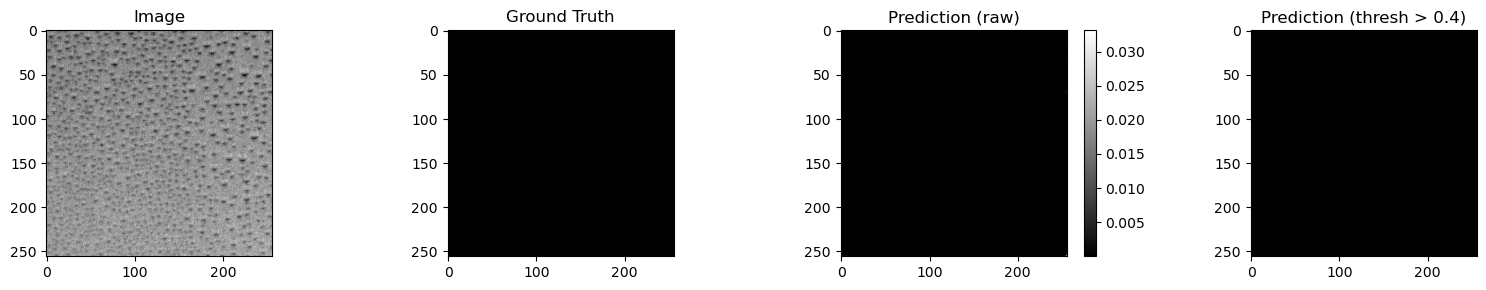

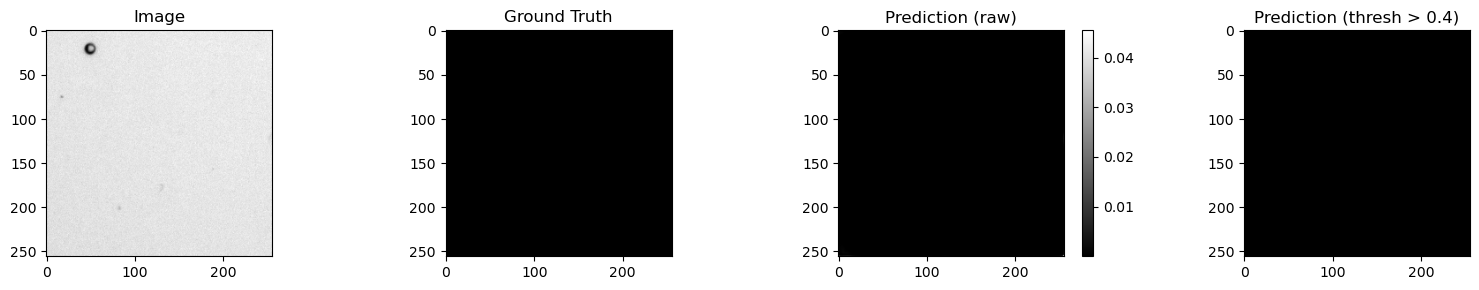

In [14]:
import matplotlib.pyplot as plt

images, masks = next(val_generator)
preds = model.predict(images)

for i in range(10):
    plt.figure(figsize=(16, 3))
    
    plt.subplot(1, 4, 1)
    plt.title("Image")
    plt.imshow(images[i].squeeze(), cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title("Ground Truth")
    plt.imshow(masks[i].squeeze(), cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title("Prediction (raw)")
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title("Prediction (thresh > 0.4)")
    plt.imshow((preds[i].squeeze() > 0.4).astype(np.uint8), cmap='gray')

    plt.tight_layout()
    plt.show()

In [15]:
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_model_predictions_with_overlay(image_dir, mask_dir, model, patch_size=256, num_patches=5, threshold=0.5):
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.png') and not f.startswith("._")]
    random.shuffle(image_filenames)

    selected = []
    for fname in image_filenames:
        img_path = os.path.join(image_dir, fname)
        mask_path = os.path.join(mask_dir, fname.replace(".png", ".tif"))

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            continue

        if np.sum(mask) >= 10:  # min_mask_pixels
            selected.append((fname, image, mask))

        if len(selected) >= num_patches:
            break

    if not selected:
        print("No suitable patches found.")
        return

    for fname, image, mask in selected:
        # Preprocess for model
        input_img = image.astype(np.float32) / 255.0
        input_img = np.expand_dims(input_img, axis=(0, -1))  # (1, H, W, 1)

        # Predict
        pred = model.predict(input_img)[0, :, :, 0]  # remove batch + channel

        # Threshold prediction
        pred_binary = (pred > threshold).astype(np.uint8)

        # Overlay on original
        overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        overlay[pred_binary == 1] = [255, 0, 0]  # red prediction

        # Prepare GT mask
        mask_display = mask.astype(np.float32) / 255.0 if mask.max() > 1 else mask.astype(np.float32)

        # Plot
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(image, cmap='gray')
        axs[0].set_title("Original Image")

        axs[1].imshow(mask_display, cmap='gray')
        axs[1].set_title("Ground Truth Mask")

        axs[2].imshow(overlay)
        axs[2].set_title("Overlay (Red = Prediction)")

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

1/1 [==============================] - 1s 573ms/step


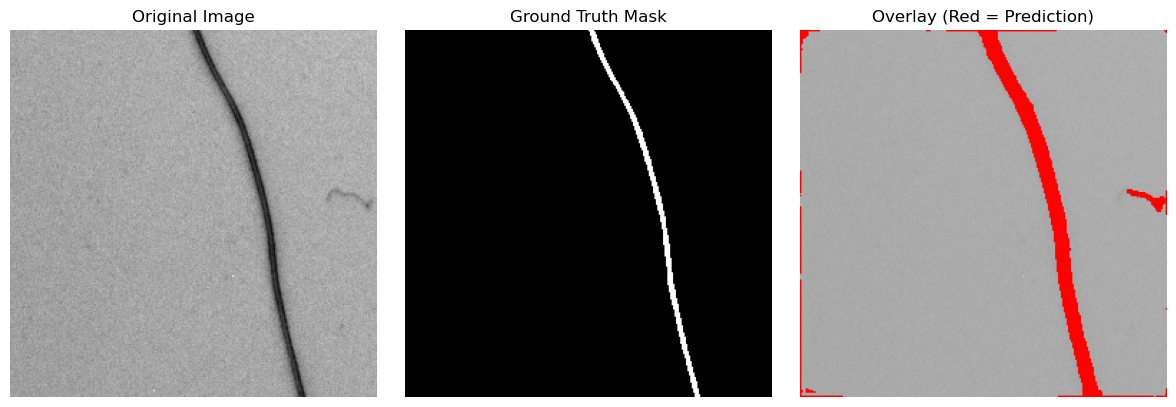

1/1 [==============================] - 0s 21ms/step


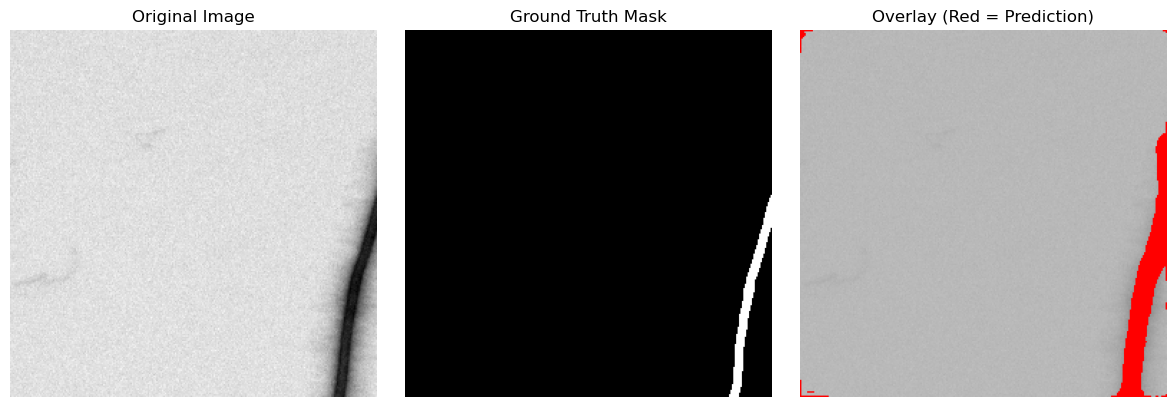

1/1 [==============================] - 0s 21ms/step


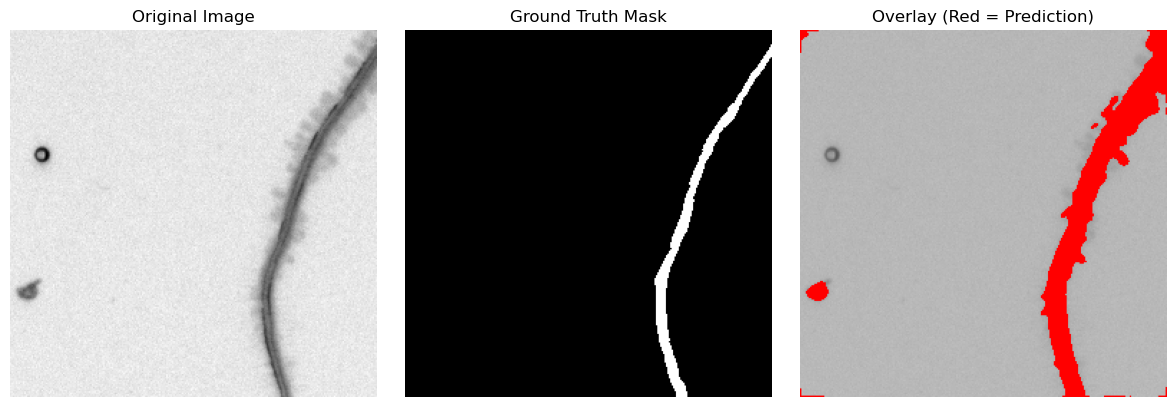

In [16]:
visualize_model_predictions_with_overlay(
    image_dir=f"{patch_dir}/val_images/val",
    mask_dir=f"{patch_dir}/val_masks/val",
    model=model,
    patch_size=256,
    num_patches=3,
    threshold=0.001  # tune if needed
)


In [17]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'dariavladutu_236578_unet_model3_{patch_size}px.h5'
print(example_file_name)
model.save(example_file_name)

dariavladutu_236578_unet_model3_256px.h5


In [18]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.003290127031505108
Best validation f1: 0.8138726353645325


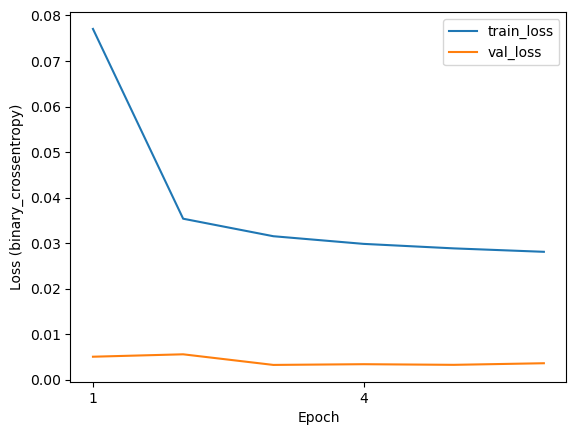

In [19]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

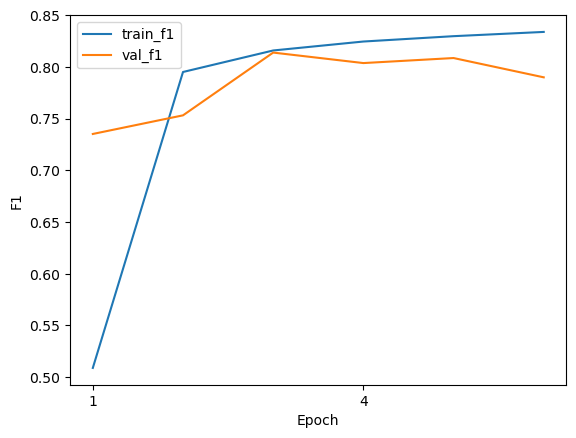

In [20]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))